In [1]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
from sklearn.linear_model import LinearRegression
import bambi as bmb
import arviz as az
import numpy as np

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#import data
data = "https://media.githubusercontent.com/media/khuyentran1401/Data-science/master/statistics/bayes_linear_regression/student-score.csv"

#create dataframe
df = pd.read_csv(data)

In [3]:
#create values for analysis
mat, por = df["mat"].values, df["por"].values

ORDINARY LEAST SQUARES LINEAR REGRESSION (OLS)

In [4]:
#scatter plot function for future use
def scat_plot(x, y, x_label, y_label):
    plt.scatter(x, y, label="sampled data")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc=0)
    plt.show()

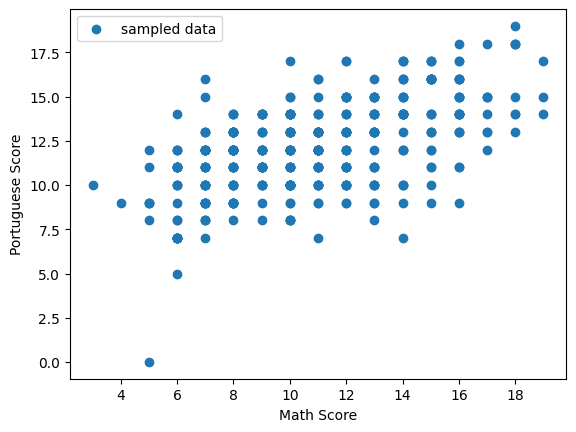

In [5]:
#Plot functions
x = df['mat']
y = df['por']
x_label = "Math Score"
y_label = "Portuguese Score"

#scatter of data
scat_plot(x, y, x_label, y_label)

In [6]:
#Import linear model for regression analysis 
linear_model = LinearRegression().fit(mat.reshape(-1,1), por)
#Generate prediction line
predict_line = linear_model.predict(mat.reshape(-1,1))

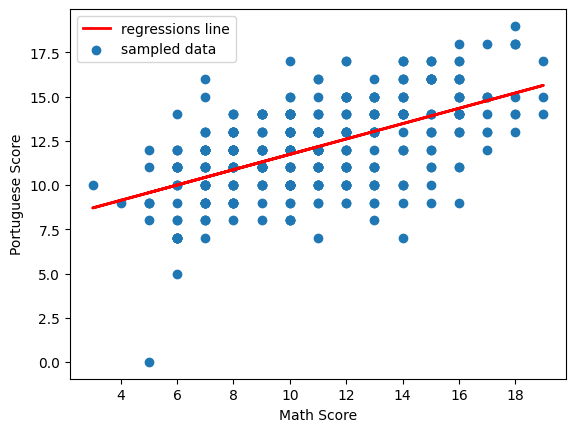

In [7]:
plt.plot(mat, predict_line, label = "regressions line", lw=2, color="red")
scat_plot(x, y, x_label, y_label)

In [8]:
#Extract coeficient
coef = linear_model.coef_[0]
coef = round(coef,3)

#Extract Intercept 
int = linear_model.intercept_
int = round(int,3)

#Equation
equation = "y = {}x + {}".format(coef, int)
print("OLS Linear Equation: " + equation)
print("If the math score increases by 1, the average Portuguese score increases by 0.43. At Portuguese score 7.403 the score is 0.")

OLS Linear Equation: y = 0.434x + 7.403
If the math score increases by 1, the average Portuguese score increases by 0.43. At Portuguese score 7.403 the score is 0.


BAYESION LINEAR REGRESSION MODEL

In [9]:
#import Gaussian model with intereactions between Portugues and Math Scores
gauss_model = bmb.Model('por ~ mat', data=df)

In [10]:
#Fit gaussian model via 1000 draws and 4 chains
gauss_fitted = gauss_model.fit(draws=1000, tune = 100, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, Intercept, mat]


Output()

Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 448 seconds.


In [11]:
#Predict outputs from guassian model
gauss_model.predict(gauss_fitted, kind="response")

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'mat'}>, <Axes: title={'center': 'mat'}>]],
      dtype=object)

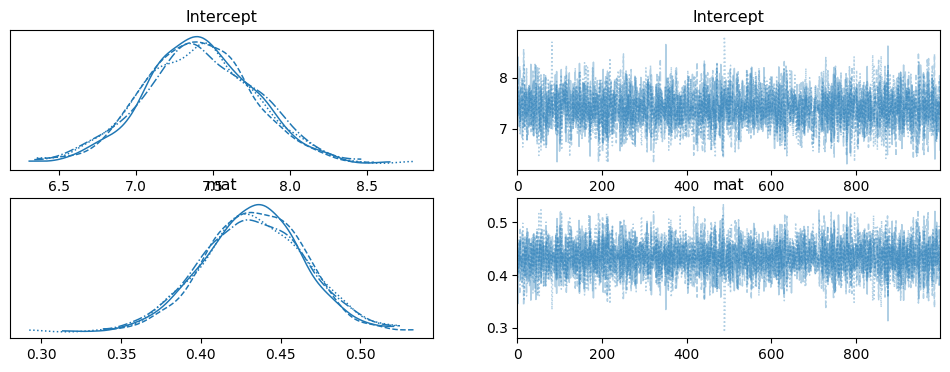

In [12]:
az.plot_trace(gauss_fitted, var_names=["Intercept", "mat"])

In [13]:
#coefficient
coef = gauss_fitted.posterior.mat.values.mean()
coef = round(coef, 3)

#intercept
int = gauss_fitted.posterior.Intercept.values.mean()
int = round(int, 3)

#Equation
equation = "y = {}x + {}".format(coef, int)
print("Bayesian Linear Equation: " + equation)
print("If the math score increases by 1, the average Portuguese score increases by {}. At Portuguese score {} the score is 0.".format(coef, int))

Bayesian Linear Equation: y = 0.433x + 7.407
If the math score increases by 1, the average Portuguese score increases by 0.43. At Portuguese score 7.402 the score is 0.


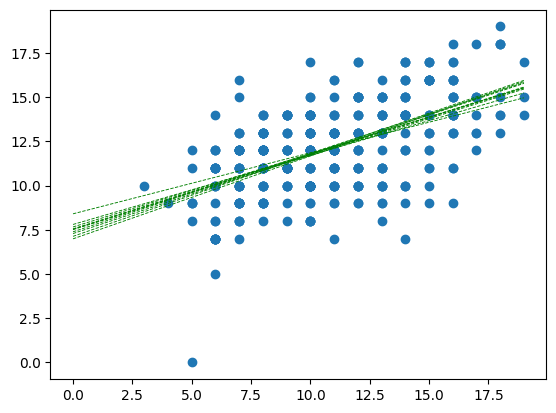

In [14]:
#plot data
plt.scatter(mat, por, label = "sampled data")

# values of x-axis
x_range = np.linspace(min(por), max(por), 2000)

#plot sample predictions
for i in range(10):
    y_pred = (gauss_fitted.posterior.mat.values[0,i] * x_range
              + gauss_fitted.posterior.Intercept.values[0,i])
    
    plt.plot(x_range, y_pred,
             color="green", linestyle="--", lw=0.65,
             label = "Mean Regression Line"
             )

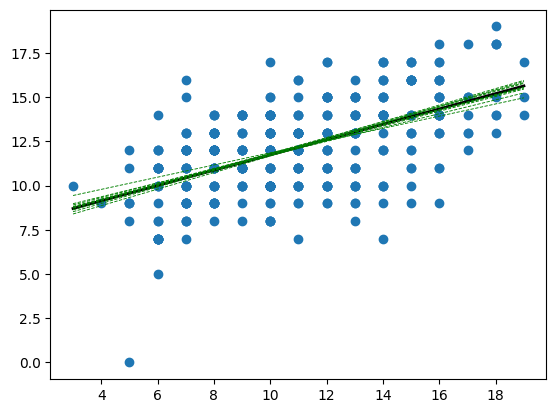

In [15]:
#Plot Data
plt.scatter(mat, por, label= "sampled data")

#Values of x-axis
x_range = np.linspace(min(mat), max(mat), 2000)

y_pred = gauss_fitted.posterior.mat.values.mean() * x_range + gauss_fitted.posterior.Intercept.values.mean()

#Plot mean prediction
plt.plot(
    x_range, y_pred,
    color="black", label="Mean regression line",
    linewidth = 2
)
#plot sample predictions
for i in range(10):
    y_pred = (gauss_fitted.posterior.mat.values[0,i] * x_range
              + gauss_fitted.posterior.Intercept.values[0,i])
    
    plt.plot(x_range, y_pred,
             color="green", linestyle="--", lw=0.65,
             label = "Mean Regression Line"
             )



<Axes: xlabel='por'>

c:\Users\moona\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\moona\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


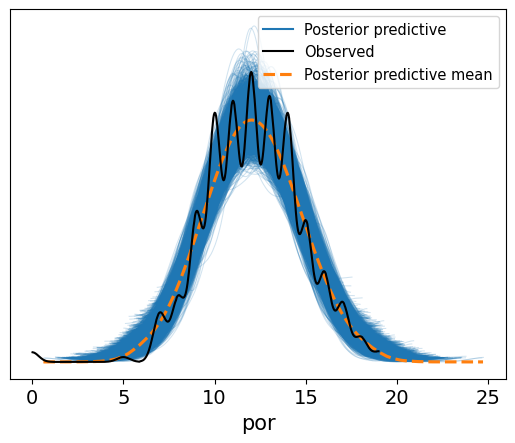

In [16]:
#Run a Posterior Predictive Check
az.plot_ppc(gauss_fitted)

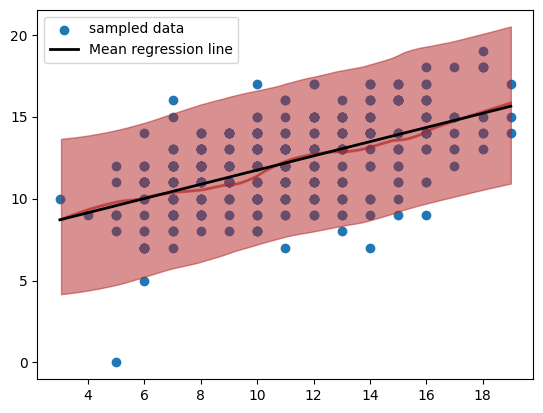

In [18]:
#Plot Data
plt.scatter(mat, por, label= "sampled data")

#Values of x-axis
x_range = np.linspace(min(mat), max(mat), 2000)

y_pred = gauss_fitted.posterior.mat.values.mean() * x_range + gauss_fitted.posterior.Intercept.values.mean()

#Plot mean prediction
plt.plot(
    x_range, y_pred,
    color="black", label="Mean regression line",
    linewidth = 2
)

#PLOT HDIs for 95% CI
for interval in [0.025, 0.975]:
    az.plot_hdi(mat, gauss_fitted.posterior_predictive.por,
                hdi_prob=interval, color="firebrick")
plt.legend(loc=0);
